In [1]:
import tensorflow as tf
from zipfile import ZipFile
import os,glob
from skimage.io import imread
from skimage.transform import resize 
import matplotlib.pyplot as plt
import random
import warnings
from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import util
from skimage import io
from sklearn import metrics
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import numpy as np
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten
#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.optimizers import sg
from keras.layers import LeakyReLU
from numpy import asarray

import cv2
import sklearn.preprocessing as preprocessing

import warnings
warnings.filterwarnings('ignore')

2023-02-22 18:48:23.300186: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/var/folders/c9/gyl6tst97217r61vrdkvhzmh0000gn/T/ipykernel_19645/1766768866.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook as tqdm


In [2]:
train_dir = '../archive/train/'
test_dir = '../archive/test/'

# Load Images into training dataset

In [3]:
def load_image_data(my_dir: str):
    
    X =[] # images
    y =[] # labels

    for filename in tqdm(os.listdir(my_dir)):
        
        # read image
        path = my_dir + filename
        img = cv2.imread(path)  
        img = cv2.resize(img,(128,128))

        X.append(img)
        y.append(filename.split('_')[1][:2]) 
    
    return X, y

In [4]:
X_train, y_train = load_image_data(train_dir)
X_test, y_test = load_image_data(test_dir)


  0%|          | 0/18000 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

In [5]:
print(np.array(X_train).shape)
print(np.array(X_test).shape)
print(np.array(y_train).shape)
print(np.array(y_test).shape)

(18000, 128, 128, 3)
(3600, 128, 128, 3)
(18000,)
(3600,)


# Visualize our training data

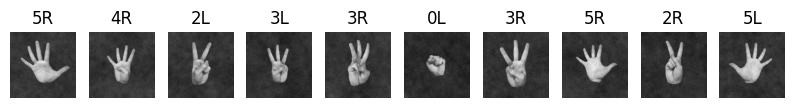

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
n_images = 10
plt.figure(figsize=(n_images, 1))
for i in range(n_images):
    plt.subplot(1, n_images, i+1)
    plt.imshow(X_train[i], cmap="gray")
    plt.axis('off')
    plt.title(y_train[i])
plt.show()

In [7]:
set(y_train)

{'0L', '0R', '1L', '1R', '2L', '2R', '3L', '3R', '4L', '4R', '5L', '5R'}

# Label Encode the Targets

In [8]:
le = preprocessing.LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=12)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=12)

y_train = np.array(y_train)
X_train = np.array(X_train)

y_test = np.array(y_test)
X_test = np.array(X_test)

In [9]:
print(y_train[0])
print("X_train Shape: ", X_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape)
print("y_test Shape: ", y_test.shape)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
X_train Shape:  (18000, 128, 128, 3)
X_test Shape:  (3600, 128, 128, 3)
y_train Shape:  (18000, 12)
y_test Shape:  (3600, 12)


In [11]:
# save le
np.save('../trained_models/le.npy', le.classes_)

# Define Model

In [12]:
img_height = img_width = 128
num_classes = y_train.shape[1]

In [13]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_augmentation = tf.keras.Sequential([
  layers.RandomRotation(0.45),
  layers.Cropping2D(cropping=((2, 2), (4, 4)))
])


model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(units = 12, activation = 'softmax')
])
model

2023-02-22 18:50:30.470109: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train Model

In [15]:
epochs = 5

In [16]:
history = model.fit(
    X_train,
    y_train,
    epochs=epochs, 
    validation_data=(X_test,y_test),
    verbose = 1,
    initial_epoch=0
)

Epoch 1/5
563/563 [==============================] - 122s 212ms/step - loss: 0.6823 - accuracy: 0.7312 - val_loss: 0.0893 - val_accuracy: 0.9753
Epoch 2/5
563/563 [==============================] - 102s 180ms/step - loss: 0.1039 - accuracy: 0.9651 - val_loss: 0.1180 - val_accuracy: 0.9622
Epoch 3/5
563/563 [==============================] - 104s 184ms/step - loss: 0.0554 - accuracy: 0.9816 - val_loss: 0.0259 - val_accuracy: 0.9936
Epoch 4/5
563/563 [==============================] - 105s 186ms/step - loss: 0.0335 - accuracy: 0.9900 - val_loss: 0.1164 - val_accuracy: 0.9564
Epoch 5/5
563/563 [==============================] - 112s 200ms/step - loss: 0.0265 - accuracy: 0.9919 - val_loss: 0.0172 - val_accuracy: 0.9944


In [17]:
# save model
model.save('../trained_models/m2')

INFO:tensorflow:Assets written to: ../trained_models/m2/assets


INFO:tensorflow:Assets written to: ../trained_models/m2/assets


# Evaluate Model

In [18]:
# Load Model
model = tf.keras.models.load_model('../trained_models/m2')

In [19]:
loss_and_metrics = model.evaluate(X_test, y_test)
print(loss_and_metrics)

113/113 [==============================] - 5s 40ms/step - loss: 0.0172 - accuracy: 0.9944
[0.01715792529284954, 0.9944444298744202]


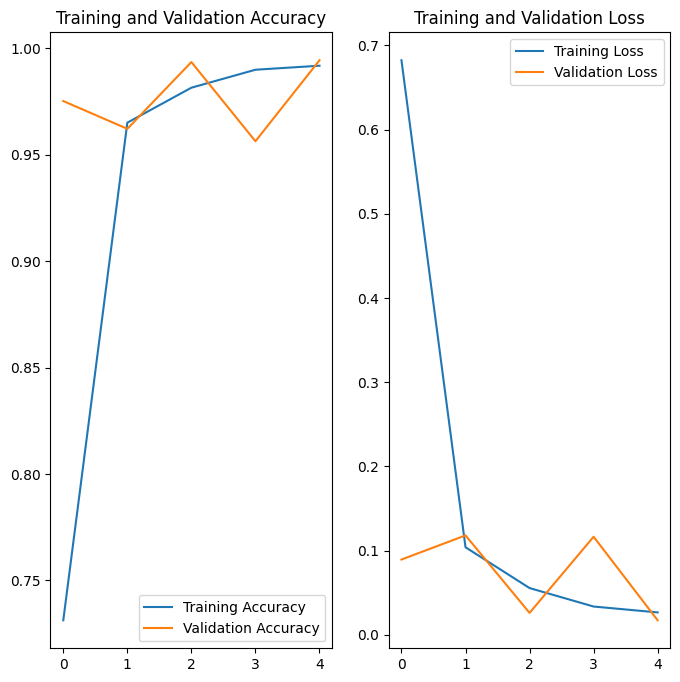

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
len(X_test)

3600

2696
True Label: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
1/1 [==============================] - 0s 124ms/step
Predicted Classes: ['2R']


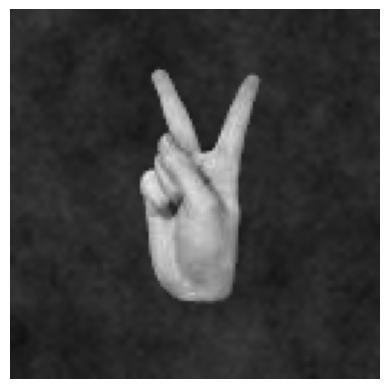

In [22]:
# Visualize Predictions
import random


def make_random_prediction():
    
    n_test_images = len(X_test)
    test_image_ind = random.randint(0, n_test_images-1)
    print(test_image_ind)
    
    true_class = y_test[test_image_ind]
    print(f'True Label: {true_class}')
    
    predicted_classes = model.predict(X_test[test_image_ind].reshape(1,128,128,3))
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    print(f'Predicted Classes: {le.inverse_transform(predicted_classes)}')
    
    plt.imshow(X_test[test_image_ind], cmap="gray")
    plt.axis('off')
    
make_random_prediction()

In [23]:
encoder = preprocessing.LabelEncoder()
encoder.classes_ = np.load('../trained_models/le.npy')

1/1 [==============================] - 0s 22ms/step


array(['0R'], dtype='<U2')

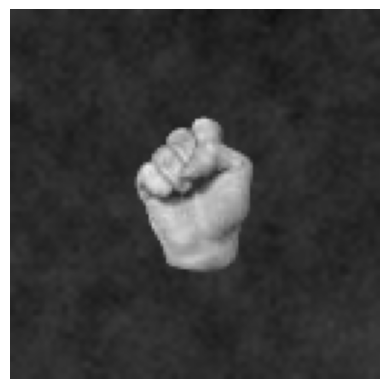

In [24]:
def make_prediction(model, le, raw_image):
    
    
    plt.imshow(raw_image, cmap="gray")
    plt.axis('off')
    
    pred = model.predict(np.array(raw_image).reshape(1,128,128,3))
    
    predicted_classes = np.argmax(np.round(pred),axis=1)
    
    return le.inverse_transform(predicted_classes)


make_prediction(model, encoder, X_test[11])